In [1]:
import numpy as np
from numpy import sqrt, cos, sin
import matplotlib
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sympy.physics.quantum import TensorProduct
from sympy import I, Matrix, symbols
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import sympy as sm
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
%matplotlib inline 
%precision 5

'%.5f'

## Problem 1 

Displacement boundary conditions are : 

+ Bottom boundary $u_y = 0$
+ Right boundary $u_x = 0.1t$
+ Top boundary $u_y = 0.1t$
+ Left boundary $u_x = 0$

The balance of linear momentum is the same as always. Either in the deformed or in the reference:

$$
\int_\Omega \sigma:\delta d = 0 \hspace{1cm} -\int_{\Omega_0}S:\delta E = 0
$$

### Second Piola Kirchhoff stress
$$
\sigma = 2c_1b^e - pI
$$

$$
S = F^{-1}\sigma F^{-T}
$$

$$
S = F^{-1}\left(2c_1b^e - 2\frac{c_1}{J^e}I\right)F^{-T}=2c_1F^{-1}\left(b^e-\frac{I}{J^e}\right)F^{-T}=2c_1\left( F^{-1}b^eF^{-T}-\frac{1}{J^e}F^{-1}F^{-T}\right)
$$

Solve every term separately:
$$
F^{-1}b^eF^{-T} \rightarrow F^{-1}\left(F^eF^{eT}\right)F^{-T} = F^{-1}\left(FF^{g-1}F^{g-1}F^{T}\right)F^{-T}=F^{g-1}F^{g-1}I = \boxed{\frac{I}{\theta^g}}
$$

$$
\frac{1}{J^e}F^{-1}F^{-T}\rightarrow\left(\frac{\theta^g}{\theta}\right)^2C^{-1}
$$

Finally we obtain:
$$
\boxed{S = 2c_1\left(\frac{I}{\theta^g}-\left(\frac{\theta^g}{\theta}\right)^2C^{-1}\right)}
$$

### Tangent

$$
\mathbb{C} = 2\frac{\partial S}{\partial C} = 2\frac{\partial S}{\partial C} + 2\frac{\partial S}{\partial \theta^g_{n+1}}\otimes \frac{\partial \theta^g_{n+1}}{\partial C}
$$

As $\theta = det(F) = J^2$, we can calculate the tangent as:

1)
$$
2\frac{\partial S}{\partial C} = 4c_1\left(\frac{1}{\theta^g}\frac{\partial I}{\partial C} - 2\frac{\theta^g}{\theta}\frac{\partial (\theta^g/\theta)}{\partial C}\otimes C^{-1} - \left(\frac{\theta^g}{\theta}\right)^2\frac{\partial C^{-1}}{\partial C}\right)
$$

$$
2\frac{\theta^g}{\theta}\frac{\partial (\theta^g/\theta)}{\partial C}\otimes C^{-1} = 2\frac{\theta^g}{\theta}\left(\frac{\partial \theta^g}{\partial C}\frac{1}{\theta} + \frac{\partial(1/\theta)}{\partial C}\theta^g\right)\otimes C^{-1} = 2\frac{\theta^g}{\theta}\left(-2J^{-3}\left(\frac{1}{2}JC^{-1}\right)\theta^g\right)\otimes C^{-1} = -2\left(\frac{\theta^g}{\theta}\right)^2C^{-1}\otimes C^{-1}
$$

$$
\boxed{2\frac{\partial S}{\partial C} = 4c_1\left(\frac{\theta^g}{\theta}\right)^2\left(2C^{-1}\otimes C^{-1} + C^{-1}\bar{\otimes} C^{-1}\right)}
$$


2)
$$
2\frac{\partial S}{\partial \theta^g_{n+1}} = 4c_1\left(\frac{\partial(1/\theta^g)}{\partial\theta^g}I - 2\frac{\theta^g}{\theta}\frac{1}{\theta}C^{-1}\right) = \boxed{-4c_1\left(\frac{I}{(\theta^g)^2} + 2\frac{\theta^g}{\theta^2}C^{-1}\right)}
$$

3)
$$
\frac{\partial \theta^g_{n+1}}{\partial C} = \frac{\partial \theta^g}{\partial C} + dtk\left(\frac{\partial J^2}{\partial C}\frac{1}{\theta^g}\right) = dtk\left(2J\left(\frac{1}{2}JC^{-1}\right)\frac{1}{\theta^g}\right) =  \boxed{\frac{dtk\theta^2}{\theta^g}C^{-1}}
$$

Tangent should be:

$$
\boxed{\mathbb{C} = 4c_1\left(\frac{\theta^g}{\theta}\right)^2\left(2C^{-1}\otimes C^{-1} + C^{-1}\bar{\otimes} C^{-1}\right) - 4c_1\left(\frac{1}{(\theta^g)^2}I + 2\frac{\theta^g}{\theta^2}C^{-1}\right)\otimes \frac{dtk\theta^2}{\theta^g}C^{-1}}
$$


In [2]:
# Compute Stress and Tangent
def SS(R,T,Cr,phir,Ce,c1,thetag,theta,Cinv):
    Iden = np.array(([1,0],[0,1]))
    pi=R*T*((Cr/(theta-phir**3))-Ce)
    S = 2*c1*((1/thetag)*Iden - (thetag/theta)**2 * Cinv) + theta*pi*Cinv
    
    return S

def CC(R,T,Cr,phir,Ce,c1,thetag,theta,Cinv,dt,k):
    # Special tensor product
    pi=R*T*((Cr/(theta-phir**3))-Ce)
    dpidJ=-(Cr*R*T)/(theta-phir**3)**2
    CC1 = np.zeros((2,2,2,2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    CC1[i,j,k,l] = 4*c1*(thetag**2/theta**2)*(2*Cinv[i,j]*Cinv[k,l] + Cinv[i,k]*Cinv[j,l]) 
                    + (theta**2*dpidJ+2*pi*theta)*(Cinv[i,j]*Cinv[k,l]) 
                    + (2*pi*theta)*(-0.5)*(Cinv[i,k]*Cinv[j,l]+Cinv[i,l]*Cinv[j,k])
#                     CC1[i,j,k,l] = 4*c1*(thetag**2/theta**2)*(2*Cinv[i,j]*Cinv[k,l] + Cinv[i,k]*Cinv[j,l]) + 
#                     (theta**2*dpidJ+2*pi*theta)*(Cinv[i,j]*Cinv[k,l]) 
#                     + (2*pi*theta)*(-0.5)*(Cinv[i,k]*Cinv[j,l]+Cinv[i,l]*Cinv[j,k])
    
    # Secon term
    Iden = np.array(([1,0],[0,1]))
    dSdtheta = ((1/thetag**2)*Iden + 2*(thetag/theta**2)*Cinv)
    dthetadc = (dt*k*theta**2/thetag)*Cinv
    CC2 = 4*c1*np.tensordot(dSdtheta, dthetadc, axes=0)
    
    CC = CC1 - CC2
    
    return CC

In [3]:
# Definition of the shape function and the derivative with respect to parent domain xi
def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

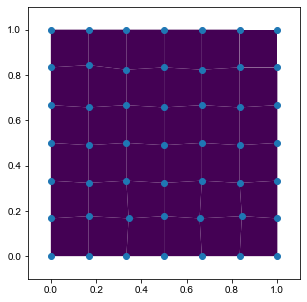

In [4]:
#nodos corriditos un poco

# MESH===================================
n_node = 49
n_elem = 36
n_IP = 49
d1=1.
d2=1.
node_X = np.array([[0.,0.],[d1,0.],[d1,d2],[0.,d2],[d1/6,0.],[d1/3,0.],[d1/2,0.],[2*d1/3,0.],[5*d1/6,0.],[d1,d2/6],
                  [d1,d2/3],[d1,d2/2],[d1,2*d2/3],[d1,5*d2/6],[5*d1/6,d2],[2*d1/3,d2],[d1/2,d2],[d1/3,d2],[d1/6,d2],
                  [0.,5*d2/6],[0.,2*d2/3],[0.,d2/2],[0.,d2/3],[0.,d2/6],[d1/6,(d2/6)+0.01],[(d1/3)+0.01,d2/6],[d1/2,(d2/6)+0.01],[(2*d1/3)-0.01,d2/6],[(5*d1/6)+0.01,(d2/6)+0.01],
                  [d1/6,(d2/3)-0.01],[d1/3,d2/3],[d1/2,(d2/3)-0.01],[2*d1/3,d2/3],[5*d1/6,(d2/3)-0.01],[d1/6,(d2/2)-0.01],[d1/3,d2/2],[d1/2,(d2/2)-0.01],[2*d1/3,d2/2],[5*d1/6,(d2/2)-0.01],
                  [d1/6,(2*d2/3)-0.01],[d1/3,2*d2/3],[d1/2,(2*d2/3)-0.01],[2*d1/3,2*d2/3],[5*d1/6,(2*d2/3)-0.01],[d1/6,(5*d2/6)+0.01],[d1/3,(5*d2/6)-0.01],[d1/2,5*d2/6],[2*d1/3,(5*d2/6)-0.01],[5*d1/6,5*d2/6]
                  ])
elements = np.array([[0,4,24,23],[4,5,25,24],[5,6,26,25],[6,7,27,26],[7,8,28,27],[8,1,9,28],
                     [23,24,29,22],[24,25,30,29],[25,26,31,30],[26,27,32,31],[27,28,33,32],[28,9,10,33],
                     [22,29,34,21],[29,30,35,34],[30,31,36,35],[31,32,37,36],[32,33,38,37],[33,10,11,38],
                     [21,34,39,20],[34,35,40,39],[35,36,41,40],[36,37,42,41],[37,38,43,42],[38,11,12,43],
                     [20,39,44,19],[39,40,45,44],[40,41,46,45],[41,42,47,46],[42,43,48,47],[43,12,13,48],
                     [19,44,18,3],[44,45,17,18],[45,46,16,17],[46,47,15,16],[47,48,14,15],[48,13,2,14]
                    ])

# PLOT MESH ==============================
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(5,5))
ax1.set_xlim([-0.1, 1.1])
ax1.set_ylim([-0.1, 1.1])
ax1.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = 0.0
p1 = PatchCollection(patches1);
p1.set_array(colors1);
ax1.add_collection(p1);
ax1.scatter(node_X[:,0],node_X[:,1]);

In [5]:
# putting it inside a function
def assembleRRKK(c1,dt,k,thetagIP,R,T,CrIP,phirIP,Ce):
    # assemble total residual 
    RR = np.zeros((n_node*2))
    # assemble the total tangent 
    KK = np.zeros((n_node*2,n_node*2))
    # loop over elements
    for ei in range(n_elem): 

        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        # Internal Variable of the IP making up this element (init to zero, fill in a loop)
        thetagIP_ei = np.zeros((4,1))
        CrIP_ei = np.zeros((4,1))
        phirIP_ei = np.zeros((4,1))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]
            thetagIP_ei[ni] = thetagIP[node_ei[ni]]
            CrIP_ei[ni] = CrIP[node_ei[ni]]
            phirIP_ei[ni] = phirIP[node_ei[ni]]
            
        # also, do a proper integration with four integration points 
        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])

            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])
             
            # compute growth constants and scalar field
            thetag = thetagIP_ei[ip]
            Cr = CrIP_ei[ip]
            phir = phirIP_ei[ip]
            Iden = np.array(([1,0],[0,1]))
            Fg = np.sqrt(thetag)*Iden
            
            # compute Theta
            detF = np.linalg.det(F)
            theta = detF
            
            # compute the stress
            detF = np.linalg.det(F)
            C = np.dot(F.transpose(),F)
            Cinv = np.linalg.inv(C)
            
            SST = SS(R,T,Cr,phir,Ce,c1,thetag,theta,Cinv)
            
            #Elasticity tensor
            CCE = CC(R,T,Cr,phir,Ce,c1,thetag,theta,Cinv,dt,k)
            D = np.array([[CCE[0,0,0,0],CCE[0,0,1,1],CCE[0,0,0,1]],\
                            [CCE[0,0,1,1],CCE[1,1,1,1],CCE[1,1,0,1]],\
                            [CCE[0,0,0,1],CCE[1,1,0,1],CCE[0,1,0,1]]])

            # compute the variation of the symmetric velocity gradient by moving one node and one component
            # of that node at a time, except if the node is on the boundary in which case no variation is allowed
            for ni in range(4):
                for ci in range(2):
                    deltau = np.zeros((2))
                    # note, no worries about the boundary because we will get rid of the corresponding rows
                    # of the residual because they wont be zero 
                    deltau[ci] = 1
                    # CAREFUL!! gradient is with respect to reference coordinates X 
                    gradX_du = np.outer(deltau,dNsdX[:,ni])
                    deltaE = 0.5*(np.dot(F.transpose(),gradX_du) + np.dot(gradX_du.transpose(),F))

                    # ASSEMBLE INTO GLOBAL RESIDUAL (I didn't ask for this)
                    RR[node_ei[ni]*2+ci] += wi*np.linalg.det(dXdxi)*np.tensordot(SST,deltaE)
                    
                    ## 2 more for loops for the increment Delta u
                    for nj in range(4):
                        for cj in range(2):
                            Deltau = np.zeros((2))
                            Deltau[cj]=1
                            gradX_Du = np.outer(Deltau,dNsdX[:,nj])
                            DeltaE = 0.5*(np.dot(F.transpose(),gradX_Du) + np.dot(gradX_Du.transpose(),F))
                            DeltadeltaE = 0.5*(np.dot(gradX_du.transpose(),gradX_Du) + np.dot(gradX_Du.transpose(),gradX_du))
                            ## ELEMENT TANGENT
                            # Initial stress component (also called geometric component)
                            Kgeom = np.tensordot(SST,DeltadeltaE)
                            # Material component, need to put things in voigt notation for easy computation
                            deltaE_voigt = np.array([deltaE[0,0],deltaE[1,1],2*deltaE[0,1]])
                            DeltaE_voigt = np.array([DeltaE[0,0],DeltaE[1,1],2*DeltaE[0,1]])
                            Kmat = np.dot(DeltaE_voigt,np.dot(D,deltaE_voigt))
                            # assemble into global 
                            KK[node_ei[ni]*2+ci,node_ei[nj]*2+cj] += wi*np.linalg.det(dXdxi)*(Kgeom+Kmat)
                            
    return RR,KK

In [6]:
# Mesh Plot
def plotmesh(tplot):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlim([-0.1, 5.5])
    ax.set_ylim([-0.1, 5.5])
    ax.set_aspect('equal')
    patches = []
    #viridis = matplotlib.cm.get_cmap('viridis', 50)
    colors = np.zeros((n_elem))
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        n4 = elements[i,3]
        polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
        patches.append(polygon)
        colors[i] = 0
    p = PatchCollection(patches)
    p.set_array(colors)
    ax.add_collection(p)
    ax.set_title('t = %f'%tplot, fontsize=16)

t =  0.000000
Res(Final t) =  0.003951
t =  0.100000
Res(Final t) =  0.007411
t =  0.200000
Res(Final t) =  0.010519
t =  0.300000
Res(Final t) =  0.013371
t =  0.400000
Res(Final t) =  0.016031
t =  0.500000
Res(Final t) =  0.018546
t =  0.600000
Res(Final t) =  0.020948
t =  0.700000
Res(Final t) =  0.023263
t =  0.800000
Res(Final t) =  0.025510
t =  0.900000
Res(Final t) =  0.027703
t =  1.000000
Res(Final t) =  0.029852


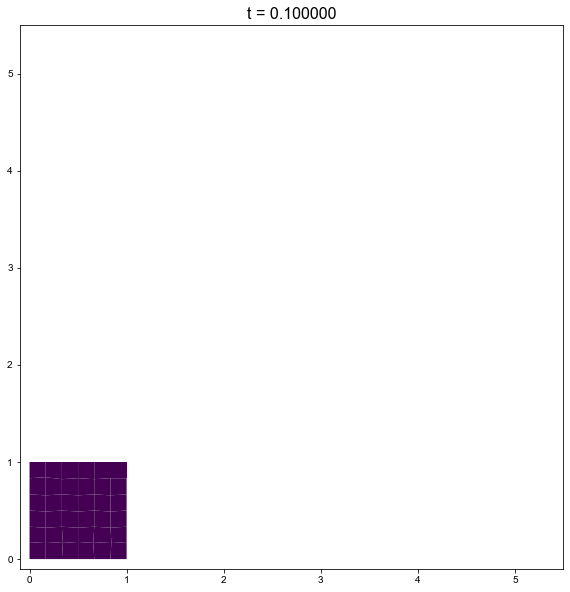

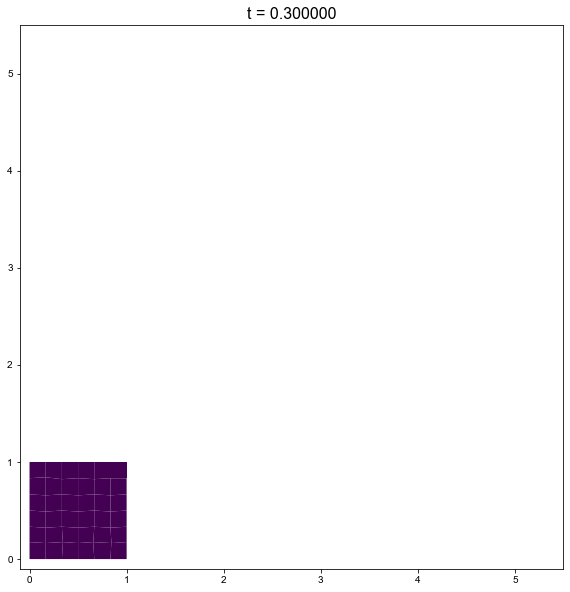

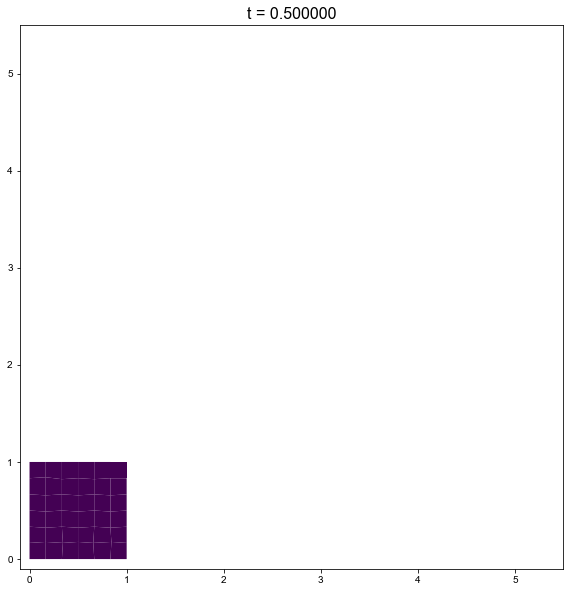

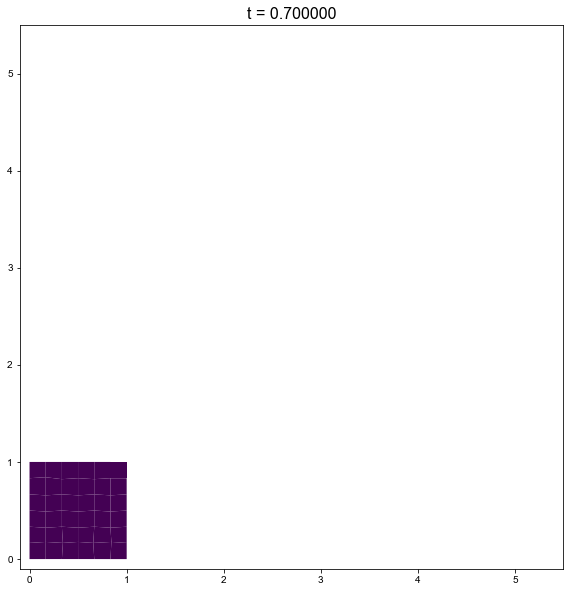

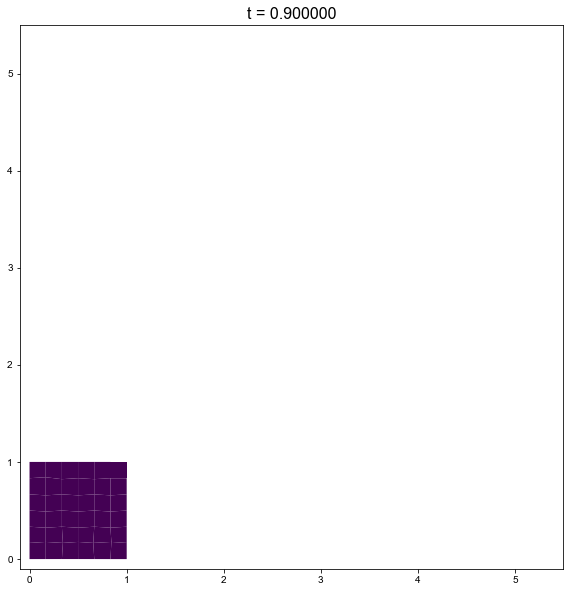

In [7]:
## Material Constants
#NEo-Hookean
c1 = 1.0
k = 1.1

thetagIP = np.ones((n_IP))

#Growth
R=8.314e-06
T=0
Ce=300
phiro=0.3
cro=210

CrIP= cro*np.ones((n_IP))
phirIP= phiro*np.ones((n_IP))
# Cr = np.ones((n_IP))
# phir = np.ones((n_IP))

total_time = 1.0

#Numeric Constants
dt = 0.1
tt = 0.

# Variable store Vectors
thetaV = []
thetagV = []
thetaeV = []
ttot = []
center_elem = 35

# Initialize Deformed Configuration
node_x = np.zeros(node_X.shape)
for i in range(n_node):
    X = node_X[i]
    node_x[i] = X
    
# Loop Over time
Mesh_Graph_count = 0
while tt<total_time:
    # BOUNDARY CONDITIONS (add 0.1dt in every time step)
    for i in range(n_node):
        X = node_X[i]
        # but then apply boundary conditions
        if X[0]<0.00001: 
            node_x[i,0] += 0.
        if X[1]<0.00001: 
            node_x[i,1] += 0.
        if X[0]>0.9999: 
            node_x[i,0] += 0.001*dt
        if X[1]>0.9999: 
            node_x[i,1] += 0.001*dt

    ## Newton Raphson LOOP
    res = 1
    iter = 0
    tol = 1e-5
    itermax = 100
    while res>tol and iter<itermax:
        RR,KK = assembleRRKK(c1,dt,k,thetagIP,R,T,CrIP,phirIP,Ce)
        # for the increment not all of the KK is needed because the first 4 nodes have essential BC
        # so we need to partition, see also the model problem solution 
        RRdof = RR[8:]
        KKdof = KK[8:,8:]
        res = np.linalg.norm(RRdof)
        incr_u = -np.linalg.solve(KKdof,RRdof)
        # and only some of the nodes need this increment
        for i in range(4):
            node_x[4+i,0] += incr_u[i*2]
            node_x[4+i,1] += incr_u[i*2+1]
        iter +=1
        #print('iter %i'%iter)
    print('t =  %f'%tt)
    print('Res(Final t) =  %f'%res)  
    
    # Update Internal Variable theta g, phir and cr
    thetaAvg = 0
    thetaAvg_g = 0
    thetaAvg_e = 0
    for ei in range(n_elem):
        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        # Internal Variable of the IP making up this element (init to zero, fill in a loop)
        thetagIP_ei = np.zeros((4,1))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]
            thetagIP_ei[ni] = thetagIP[node_ei[ni]]

        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]

            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])

            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])

            # compute growth constants
            thetag = thetagIP_ei[ip]
#             print(thetag)
            Iden = np.array(([1,0],[0,1]))
            Fg = np.sqrt(thetag)*Iden
            
            # Theta
            theta = np.linalg.det(F)
            
            #Theta e
            Fe = np.dot(F,np.linalg.inv(Fg))
            thetae = np.linalg.det(Fe)
            
            # Update Growth
            thetagIP[node_ei[ip]] += dt*k*((theta/thetag) - 1)
            CrIP[node_ei[ip]] += dt*210
            phirIP[node_ei[ip]] += dt*0.3
            
            # Save elements to plot
            if ei == center_elem:
                thetaAvg += theta
                thetaAvg_g += thetag
                thetaAvg_e += thetae
        
    thetaV.append(thetaAvg/4)
    thetagV.append(thetaAvg_g/4)
    thetaeV.append(thetaAvg_e/4)
    ttot.append(tt)  
    # Next Time step
    Mesh_Graph_count += 1
    if Mesh_Graph_count>1:
        plotmesh(tt)
        Mesh_Graph_count = 0
    tt += dt

### g)

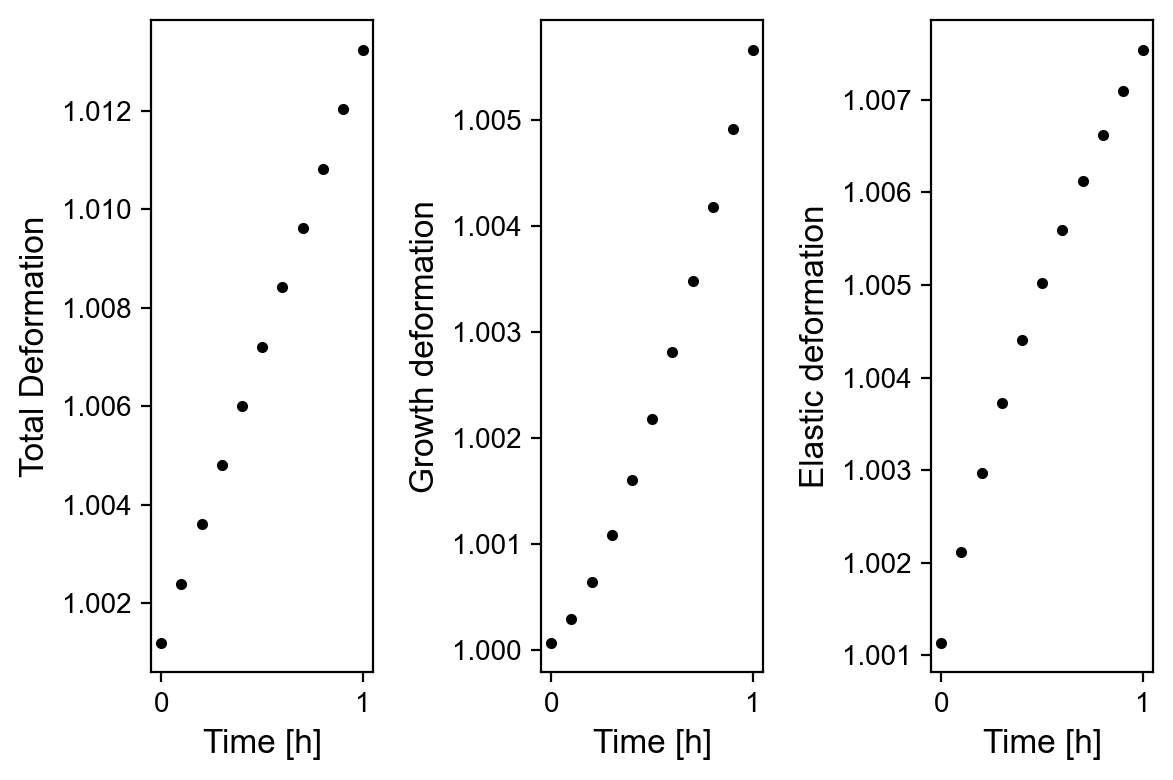

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_dpi(200)
# Total deformation as fuction of time (Center Element)
ax1.plot(ttot, thetaV, '.k')
ax1.set_xlabel('Time [h]', fontsize=12)
ax1.set_ylabel('Total Deformation', fontsize=12);

# Growth deformation (Center Element)
ax2.plot(ttot, thetagV, '.k')
ax2.set_xlabel('Time [h]', fontsize=12)
ax2.set_ylabel('Growth deformation', fontsize=12);

# Elastic deformation (Center Element)
ax3.plot(ttot, thetaeV, '.k')
ax3.set_xlabel('Time [h]', fontsize=12)
ax3.set_ylabel('Elastic deformation', fontsize=12);
fig.tight_layout()